# Fast Algorithm for Independent Component Analysis (FastICA)


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

FastICA is an efficient and popular algorithm for independent component analysis invented by Aapo Hyvärinen at Helsinki University of Technology. Like most ICA algorithms, FastICA seeks an orthogonal rotation of prewhitened data, through a fixed-point iteration scheme, that maximizes a measure of non-Gaussianity of the rotated components. Non-gaussianity serves as a proxy for statistical independence, which is a very strong condition and requires infinite data to verify. FastICA can also be alternatively derived as an approximative Newton iteration.

ICA is a dimensionality reduction approach, and could find the most salient information of the dataset. This is an unsupervised problem, and could detect anomalies without labelling them before. This approach could be adapted to newly emerging patterns of fraud as quickly as possible.

Independent component analysis attempts to decompose a multivariate signal into independent non-Gaussian signals. 

ref:
https://www.oreilly.com/library/view/hands-on-unsupervised-learning/9781492035633/ch04.html

## Mathematical Definitions
The data are represented by the observed random vector $x=(x_{1},\ldots ,x_{m})^{T}$ and the hidden components as the random vector $s=(s_{1},\ldots ,s_{n})^{T}$. The task is to transform the observed data $(x_{1},\ldots ,x_{m})^{T}$ using a linear static transformation $W$ as $s=Wx$, into a vector of maximally independent components $s$ measured by some function $F(s_{1},\ldots ,s_{n})$ of independence.

In the context of our smart grid signal dataset, the algorithms will have the largest reconstruction error on those time points that are hardest to model in other words, those that occur the least often and are the most anomalous. Since cyber attack is rare and presumably different than normal signals, the anomaly time points should exhibit the largest reconstruction error. So let’s define the anomaly score as the reconstruction error. The reconstruction error for each signal at some time point is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

The signal of some time point that have the largest sum of squared differences will have an error close to one, while those that have the smallest sum of squared differences will have an error close to zero.

This approach could be used for detecting anomalies in multivariate time series.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [6]:

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

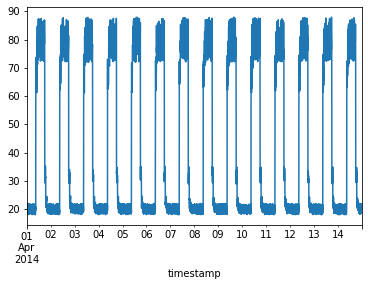

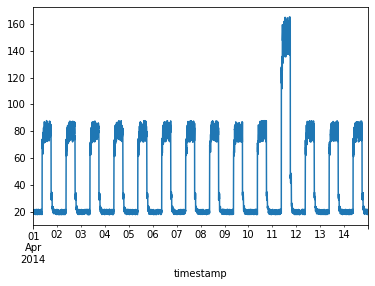

In [7]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [41]:

# Normalize and save the mean and std we get,
# for normalizing test data.

TIME_STEPS = 2



def ICA_anomaly_detection(x_train, x_test, time_steps=TIME_STEPS):
    training_mean = x_train.mean()
    training_std = x_train.std()
    df_training_value = (x_train - training_mean) / training_std
    print("Number of training samples:", len(df_training_value))

    x_train = df_training_value.values
    print("Training input shape: ", x_train.shape)

    n_components = 7
    algorithm = 'parallel'
    whiten = True
    max_iter = 200
    random_state = 2018

    fastICA = FastICA(n_components=n_components, \
      algorithm=algorithm, whiten=whiten, max_iter=max_iter, \
      random_state=random_state)
    
    X_train_fastICA = fastICA.fit_transform(x_train)
    #X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=x_train.index)

    X_train_fastICA_inverse = fastICA.inverse_transform(X_train_fastICA)
    #X_train_fastICA_inverse = pd.DataFrame(data=X_train_fastICA_inverse, \
    #                                      index=x_train.index)


    # Get train MAE loss.
    x_train_pred = X_train_fastICA_inverse
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)


##### test ...

    test_mean = x_test.mean()
    test_std = x_test.std()
    ####### prepare the test data
    df_test_value = (x_test - test_mean) / test_std
    #fig, ax = plt.subplots()
    #df_test_value.plot(legend=False, ax=ax)
    #plt.show()

    x_test = df_test_value.values
    print("Test input shape: ", x_test.shape)

    # Get test MAE loss.
    X_test_fastICA = fastICA.fit_transform(x_test)
    #X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=x_train.index)

    X_test_fastICA_inverse = fastICA.inverse_transform(X_test_fastICA)

    x_test_pred = X_test_fastICA_inverse
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold
    print("Number of anomaly samples: ", np.sum(anomalies))
    #print("Indices of anomaly samples: ", np.where(anomalies))
    return anomalies

Number of training samples: 4032
Training input shape:  (4032, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 1
  % n_components


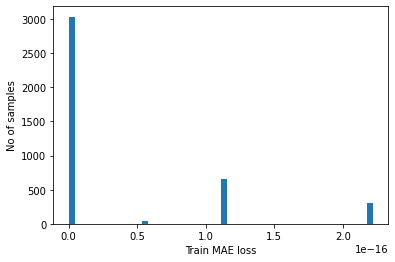

Reconstruction error threshold:  2.220446049250313e-16
Test input shape:  (4032, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 1
  % n_components


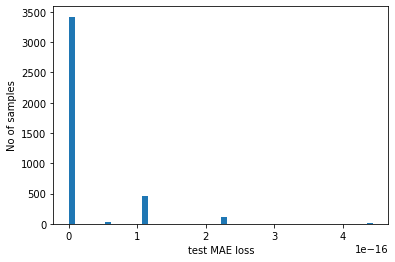

Number of anomaly samples:  15


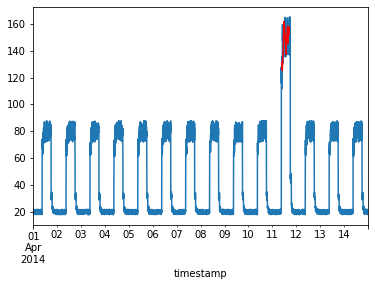

In [42]:

##### plot anomalies
anomalies = ICA_anomaly_detection(df_small_noise, df_daily_jumpsup, time_steps=TIME_STEPS)

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
test_mean = df_daily_jumpsup.mean()
test_std = df_daily_jumpsup.std()
df_test_value = (df_daily_jumpsup - test_mean) / test_std

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [4]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7,random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(1797, 7)